# Neural Network By Hand

This notebook illustrates how to train a very basic neural network "by hand." This will use the python package ``numpy`` for matrix/array computing. It has all the basic functionality that MATLAB has.

This notebook is going to go through the calculus of training a network and everything will be done "by hand" in ``numpy``. There are libraries designed for making neural networks that will handle the calculus for us (``scikit-learn`` has lots of basic machine learning algorithms implemented to where you only need 3ish lines of code to train them; ``pytorch`` and ``tensorflow`` require you to know how to put the algorithms together - meaning, they're more flexible - while still handling all the calculus for you). The later notebooks will not include any calculus.

The goal of the Boston House Prices dataset is to ingest 13 features about a house and the neighborhood the house is in, and to predict how much the house will cost. Since the price is a real number that can take on (almost) any value, this is a **regression** problem. We'll discuss the other main type of prediction, **classification**, later.

In [1]:
import numpy as np  # numpy for matrix/array computing

In [2]:
from sklearn.datasets import load_boston  # we're going to use scikit-learn ONLY for the Boston dataset.

In [3]:
dataset = load_boston()
print(dataset["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

I'm going to use the notation ``(R, C)`` for the shape of arrays. That indicates a 2-dimensional array (i.e., a matrix) with ``R`` rows and ``C`` columns. I'll use ``(D,)`` for a 1-dimensional array (i.e., a vector) with ``D`` elements. The notation extends to higher-dimensional arrays, which we'll see later. The fancy lingo for N-dimensional arrays is **tensors**. 

In [4]:
# Let's explore the format the data is in
print(dataset.keys())
data = dataset["data"]  # np.ndarray - shape: (examples, features)
target = dataset["target"]  # np.ndarray - shape: (examples,)
print("Data shape:", data.shape)
print("Features:", dataset["feature_names"])
print("Target shape:", target.shape)

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])
Data shape: (506, 13)
Features: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
Target shape: (506,)


## Linear Model

Now let's begin talking about machine learning.

Let's see how well we can predict the price of houses based on the features in the Boston house dataset.
For a specific house, let's call the features $x_0, x_1, \dots, x_{12}$ and let's call the price $y$. (Sometimes, we'll use a dataset index, but we're omitting that until it's necessary.) We're going to try to learn how to predict $y$ as a weighted average of the features $x_i$. In other words,
$$ \hat{y} = w_{0} x_0 + w_1 x_1 + \dots w_{12} + x_{12} $$
where $\hat{y}$ is our estimate for $y$ and the weights $w_i$ are twelve real numbers that we're going to find numerically.

Two notational conveniences: First, we can write $\hat{y}$ as a function of $x_i$ and $w_i$:
$$ \hat{y}(x_0, \dots, x_{12}, w_0, \dots, x_{12}) = w_0 x_0 + \dots + w_{12} x_{12}.$$

Second, the formula $\hat{y} = \sum_k w_k x_k$ is instantly recognizable as the formula for dot product, so we can actually simply write
$$ \hat{y} = \vec{w} \cdot \vec{x}. $$

Recall from linear algebra that we can express the dot product as a matrix multiplication. More on that later.

In [5]:
X = data  # X matrix is all the data
Y = target  # Y matrix is all the truth

How are we going to find the weights $w_i$? Well, more basic algorithms like least-squares work here, but let's introduce a concept called **gradient descent** that's much more general.

The idea is very similar to least-squares regression. We're going to define an **error function** $E(y, \hat{y})$, also sometimes called the **cost function** or the **loss function**, and we're going to try to minimize the sum (or average) of the error across the whole dataset, i.e. for all $y$. So far so good.

Naive approach: Let's choose random numbers for $w_i$'s. Then, for each $i$, let's try to make it a little bigger. If the error goes down, good. Keep making that weight bigger. If the error goes up, oops. Make that weight smaller.

Issues: That would take forever. And, we don't really know how much to make the weight bigger or smaller.

Idea: But wait a minute! What if I could tell you how much the error changes as each $w_i$ changes without having to change $w_i$? What if you could just find $E(y, \hat{y})$ and automatically know which way to change $w_i$?

This is sounding like a derivative...

As long as $E(y, \hat{y}(x_0, \dots, x_{12}, w_0, \dots, w_{12}))$ has partial derivatives with respect to the weights $w_i$, we're good. We can tell immediately which way to change each weight when presented with $\vec{x}$ and $y$.

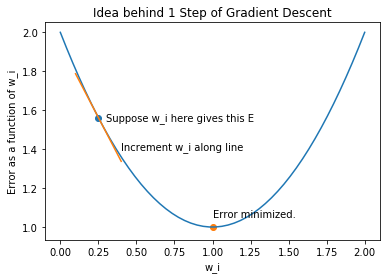

In [6]:
# this code is for the plot below, skip reading this and look at the plot

import matplotlib.pyplot as plt  # plotting library for python

w_i = np.linspace(0, 2)
E = (w_i - 1) ** 2 + 1
plt.plot(w_i, E)
plt.xlabel("w_i")
plt.ylabel("Error as a function of w_i")
plt.title("Idea behind 1 Step of Gradient Descent")

current_w_i = 0.25  # a
current_E = (current_w_i - 1) ** 2 + 1

plt.scatter(current_w_i, current_E)
plt.text(0.3, 1.55, "Suppose w_i here gives this E")

plt.scatter([1], [1])  # plot the minimum
plt.text(1, 1.05, "Error minimized.")

# tangent line of E about the point w_i=a:
# L(w_i) = f(a) + dE(a) \times (w_i - a)
w_i_local = np.linspace(0.1, 0.4)
slope = 2 * (current_w_i - 1)
line = current_E + slope * (w_i_local - current_w_i)
plt.plot(w_i_local, line)

_ = plt.text(0.4, 1.4, "Increment w_i along line")

In [7]:
# Let's get our initial random weights.
w = np.random.randn(13, 1)  # (features, 1) weights arranged as a column vector

def y_hat(x, w):
    # x is a (1, 13) row vector
    # w is a (13, 1) column vector
    # we can find the weighted sum w0 x0 + ... + w12 x12 by matrix multiplying the vectors
    return x @ w  # "@" is shorthand for matrix multiply in python. The result should be a 1x1 matrix

estimate = y_hat(X[0, :], w)
print(estimate)  # perfect, we got a number!

[527.29820234]


Our error function is going to be the squared error function:
$$ E(y, \hat{y}) = (y - \hat{y})^2 $$
and when we sum the error across all $y$, we have (adding the dataset index $n$):
$$ \sum_{n=1}^N E(y_n, \hat{y}_n) = \sum_{n=1}^N (y_n - \hat{y}_n)^2 = \text{SSE}.$$
In other words, across the whole dataset, we are minimizing the sum-squared error.

Let's give that a name: The total error function 
$$ E_T(Y, \hat{Y}) = \text{SSE} = \sum_{n=1}^N (y_n - \hat{y}_n)^2. $$


Let's do the calculus to find $\frac{\partial E_T}{\partial w_i}$:

Leibniz chain rule:
$$ \frac{\partial E_T}{\partial w_i} = \frac{\partial E_T}{\partial \hat{y}_k} \frac{\partial \hat{y}_k}{\partial w_i}. $$

$$ \frac{\partial E_T}{\partial \hat{y}_k} = \frac{\partial}{\partial \hat{y}_n} ((y_0 - \hat{y}_0)^2 + \dots (y_k - \hat{y}_k)^2 + \dots + (y_N - \hat{y}_N)^2) = \frac{\partial}{\partial \hat{y}_k} (y_k - \hat{y}_k)^2 = 2 (y_k - \hat{y}_k) \times (-1) = 2 (\hat{y}_k - y_k).$$
$$ \frac{\partial \hat{y}_k}{\partial w_i} = x_{k_i}.$$
So,
$$ \frac{\partial E_T}{\partial w_i} = 2 (\hat{y}_k - y_k) \times x_{k_i}.$$

Note that our derivative implicitly depends on the dataset index $k$.
We don't actually want that.
We'll actually estimate $\frac{\partial E_T}{\partial w_i}$ by averaging it across the entire dataset.
But we will not write that detail in the math for notational convenience.

The gradient of $E_T$ is given by:
$$ \nabla E_T = [\frac{\partial E_T}{\partial w_0}, \dots, \frac{\partial E_T}{\partial w_{12}}].$$

How are we going to update the weights?
Well, let's try just changing them by how much they change the error. If a weight hurts the error a lot if we increase it ($\frac{\partial E_T}{\partial w_i}$ is a large positive number), let's reduce $w_i$ quite a bit, etc. We're going to scale that by a factor of $\eta$, called the **learning rate**.
$$ w_i \leftarrow w_i - \eta \frac{\partial E_T}{\partial w_i}.$$

We can rewrite using linear algebra:
$$ \vec{w} \leftarrow \vec{w} - \eta \nabla E_T.$$
This is the **update rule.**

In [8]:
# in practice, for technical reasons, it is VERY important to somehow normalize the different features.
# There's different approaches:
# zero-mean, unit-variance is common
#     when we assume the values of each feature are normally distributed across the dataset
# rescaling to a range of [-1, 1] is also common, but hurt badly by outliers.
#
# We're going to do zero-mean, unit variance. We'll take each feature column,
# subtract it's mean, and divide by its standard deviation

def zero_mean_unit_variance(D):
    # D is a data matrix shaped (N_feats, ...)
    feat_means = np.mean(D, axis=0)  # (N_feats,)-shaped vector
    feat_vars = np.var(D, axis=0)  # (N_feats,)-shaped vector

    # variance of 0 means an uninformative/constant feature.
    # numerically, it's a problem b/c we can't divide by zero
    try:
        print("Check minimum variance is far from 0:", min(feat_vars))
    except Exception as e:
        print("Check minimum variance is far from 0:", feat_vars)


    D_normed = (D - feat_means) / np.sqrt(feat_vars)
    return D_normed, feat_means, feat_vars

# keep means and vars to unnormalize, or to normalize new data the same way your weights are trained for
print("Normalizing X...")
X_normed, X_means, X_vars = zero_mean_unit_variance(X)
print("Normalizing Y...")
Y_normed, Y_mean, Y_var = zero_mean_unit_variance(Y)

Normalizing X...
Check minimum variance is far from 0: 0.013401098888632884
Normalizing Y...
Check minimum variance is far from 0: 84.41955615616556


### Our First Neural Network

In [9]:
# (features, 1) weights arranged as a column vector, drawn from a standard normal distribution
w = np.random.randn(13, 1)

lr = .01  # learning rate eta

def total_error(w, X_normed, Y_normed):
    # keep in mind Y is normalized so this error is meaningless in the absolute sense.
    # It's only useful relatively.
    error_T = 0
    for xk, yk in zip(X_normed, Y_normed):
        xk = xk[np.newaxis, :]  # xk (num_feats,) -> (1,num_feats)
        y_hat_k = y_hat(xk, w)
        error = (y_hat_k - yk)**2
        error_T += error
    return error_T


update_every = 100  # how many epochs do we want before printing some update about the error?


N_epochs = 2000  # number of total passes through the data
for epoch in range(1, N_epochs+1):
    gradient_sum = np.zeros_like(w)
    N = X_normed.shape[0]  # dataset size
    for xk, yk in zip(X_normed, Y_normed):
        # reshape the data to match the networks' expectations
        xk = xk[np.newaxis, :]  # xk (num_feats,) -> (1,num_feats)
        
        # run the network: This is called the "forward pass".
        y_hat_k = y_hat(xk, w)
        
        # accumulate the gradients.
        grad_E_T_k = 2 * (y_hat_k - yk) * xk.T  # grad_E_T_k (num_feats,1)
        gradient_sum += grad_E_T_k

    # update the network: This is called the "backward pass"
    gradient_average = gradient_sum / N
    w = w - lr * gradient_average
    
    if epoch % update_every == 0:
        print(f"Error after {epoch}th update:", total_error(w, X_normed, Y_normed))

Error after 100th update: [[286.47730386]]
Error after 200th update: [[203.27167844]]
Error after 300th update: [[171.20421651]]
Error after 400th update: [[156.06559724]]
Error after 500th update: [[147.966751]]
Error after 600th update: [[143.1560225]]
Error after 700th update: [[140.0352819]]
Error after 800th update: [[137.87125248]]
Error after 900th update: [[136.30125957]]
Error after 1000th update: [[135.12965626]]
Error after 1100th update: [[134.24064192]]
Error after 1200th update: [[133.55957312]]
Error after 1300th update: [[133.03498845]]
Error after 1400th update: [[132.62971248]]
Error after 1500th update: [[132.31608239]]
Error after 1600th update: [[132.07314561]]
Error after 1700th update: [[131.88486841]]
Error after 1800th update: [[131.73890942]]
Error after 1900th update: [[131.62573803]]
Error after 2000th update: [[131.53798063]]


In [10]:
for k in range(1, 10+1):
    y_hat_k = y_hat(X_normed[k, :].T, w)
    y_unnormed_hat_k = np.sqrt(Y_var) * (y_hat_k) + Y_mean
    y_k = Y[k]

    print(f"For house {k}, true price is ${y_k}K")
    print(f"We estimated ${y_unnormed_hat_k[0]}K")
    print()

For house 1, true price is $21.6K
We estimated $24.96082905537492K

For house 2, true price is $34.7K
We estimated $30.553738254477572K

For house 3, true price is $33.4K
We estimated $28.61396713526304K

For house 4, true price is $36.2K
We estimated $27.955750295148512K

For house 5, true price is $28.7K
We estimated $25.221351956742506K

For house 6, true price is $22.9K
We estimated $22.930951068414963K

For house 7, true price is $27.1K
We estimated $19.45451737777169K

For house 8, true price is $16.5K
We estimated $11.438377852391504K

For house 9, true price is $18.9K
We estimated $18.83090096056732K

For house 10, true price is $15.0K
We estimated $18.93316695577728K



### Best Practices - Splitting the Data & Parallelizing

We really want to know how our neural network did on data that it was never trained on, e.g. how well it generalizes. So, we should actually use a training and test split.

For technical reasons, sometimes we want a third dataset called a validation dataset. We'll skip that here.
This is a clear and concise explanation of the splits: https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7 (3 min)

It's also important that we don't include the test set in the dataset normalization, because that's cheating :)

In [11]:
import random
random.seed(4242)  # set the random seed so this is reproducable

In [12]:
# shuffle the data in the same way (that way the X and Y arrays are still parallel)
data_index_array = list(range(X.shape[0]))
random.shuffle(data_index_array)
X_shuf = X[data_index_array]
Y_shuf = Y[data_index_array]

# normally you use about 80% for training and 20% for testing (which is what we're doing here).
# There's about 500 houses in the dataset.
# We're going to choose a random 400 for training and use the rest for testing.
X_train = X[:400]  # since X, Y are shuffled, the first 400 are random.
Y_train = Y[:400]

X_test = X[400:]
Y_test = Y[400:]

X_norm_train, X_mean, X_var = zero_mean_unit_variance(X_train)
X_norm_test = (X_test - X_mean) / np.sqrt(X_var)
Y_norm_train, Y_mean, Y_var = zero_mean_unit_variance(Y_train)


Check minimum variance is far from 0: 0.012945226004437496
Check minimum variance is far from 0: 83.80700974999999


We can also calculate $\hat{y}_k$ for more than one $x_k$ at a time. This is called **parallelization** or **batching**.

In [13]:
def y_hat(X, w):
    # X is a data array of shape (N_samples, N_feats)
    # w is the weights vector of shape (N_feats, 1)
    # Output Y_hat = X @ w  has shape (N_samples, 1) is the prediction for each data sample X
    
    # Recall we said x @ w is the dot product between x and w.
    # Well, matrix multiplication is actually just parallel dot products
    return X @ w

For this example, the dataset is actually small enough we could actually calculate ``Y_hat`` across the entire dataset. Usually, this isn't the case. So, we'll "mini-batch."

In [14]:
# (features, 1) weights arranged as a column vector, drawn from a standard normal distribution
w = np.random.randn(13, 1)

lr = .005  # learning rate eta
batch_size = 100

def batchify(X, Y, n):
    # this weird function is what's called a generator.
    # Don't worry too much about it. Just know that we can write a for-loop
    # that iterates over what this function returns.
    for i in range(0, len(X), n):
        yield X[i:i + n], Y[i:i+n]

def total_error(w, X, Y, y_var=None, y_mean=None):
    # If y_var and y_mean are provided, we'll go ahead and unnormalize
    # to give a real absolute error.
    error_T = 0
    for X_batch, Y_batch in batchify(X, Y, batch_size):
        Y_batch = Y_batch[:, np.newaxis]  # (num_samples, 1)
        Y_hat = y_hat(X_batch, w)  # (num_samples, 1)
        if y_var is not None:
            Y_hat = Y_hat * np.sqrt(y_var) + y_mean
        error = (Y_hat - Y_batch)**2  # (num_samples, 1)
        error_t = np.sum(error)
        error_T += error_t
    return error_T


update_every = 100


N_epochs = 1200  # number of total passes through the data
for epoch in range(1, N_epochs+1):
    gradient_sum = np.zeros_like(w)
    N = X_norm_train.shape[0]  # dataset size
    for X_batch, Y_batch in batchify(X_norm_train, Y_norm_train, batch_size):
        # X_batch (num_samples,num_feats)
        Y_batch = Y_batch[:, np.newaxis]  # expand to (num_samples, 1)
        
        # forward pass
        Y_hat = y_hat(X_batch, w)  # Y_hat (num_samples,1)
        
        # gradient accumulation
        grad_E_T_batch = 2 * (Y_hat - Y_batch) * X_batch  # grad_E_T_k (num_samples, num_feats)
        # reduce to (1,num_feats) and flip back to shape of w
        gradient_sum += np.sum(grad_E_T_batch, axis=0, keepdims=True).T

    # backwards pass
    gradient_average = gradient_sum / N
    w = w - lr * gradient_average
    
    if epoch % update_every == 0:
        error = total_error(w, X_norm_train, Y_train, y_var=Y_var, y_mean=Y_mean)
        mean_error = error / X_train.shape[0]
        print(f"Mean training error (real) after {epoch}th update:", f"${mean_error:.2f}k")
        
        error = total_error(w, X_norm_test, Y_test, y_var=Y_var, y_mean=Y_mean)
        mean_error = error / X_test.shape[0]
        print(f"Mean testing error (real) after {epoch}th update:", f"${mean_error:.2f}k")
        
        print()

Mean training error (real) after 100th update: $158.29k
Mean testing error (real) after 100th update: $201.21k

Mean training error (real) after 200th update: $93.15k
Mean testing error (real) after 200th update: $96.30k

Mean training error (real) after 300th update: $65.89k
Mean testing error (real) after 300th update: $68.81k

Mean training error (real) after 400th update: $50.55k
Mean testing error (real) after 400th update: $57.11k

Mean training error (real) after 500th update: $41.13k
Mean testing error (real) after 500th update: $50.72k

Mean training error (real) after 600th update: $35.07k
Mean testing error (real) after 600th update: $46.64k

Mean training error (real) after 700th update: $31.06k
Mean testing error (real) after 700th update: $43.83k

Mean training error (real) after 800th update: $28.36k
Mean testing error (real) after 800th update: $41.83k

Mean training error (real) after 900th update: $26.52k
Mean testing error (real) after 900th update: $40.40k

Mean tra

In [15]:
samples = range(10)
y_hat_k = y_hat(X_norm_test[samples, :], w)
y_unnormed_hat_k = np.sqrt(Y_var) * (y_hat_k) + Y_mean

for k in samples:
    print(f"For house {k+1}, true price is ${Y[k]}K")
    print(f"We estimated ${y_unnormed_hat_k[k][0]}K")
    print()

For house 1, true price is $24.0K
We estimated $12.99474267544698K

For house 2, true price is $21.6K
We estimated $20.060801342612976K

For house 3, true price is $34.7K
We estimated $21.088554112016904K

For house 4, true price is $33.4K
We estimated $12.85435516448003K

For house 5, true price is $36.2K
We estimated $7.1710974627689446K

For house 6, true price is $28.7K
We estimated $5.9086641290990265K

For house 7, true price is $22.9K
We estimated $4.904890362166736K

For house 8, true price is $27.1K
We estimated $20.121206910800716K

For house 9, true price is $16.5K
We estimated $13.547181082849228K

For house 10, true price is $18.9K
We estimated $22.13049980774101K



## How Can We Do Better?

Honestly, our results still aren't very good. How can we make our network better?

One simple idea is adding a **bias**, or turning our network into an *affine transformation* instead of a linear one.
For example,
$$ \hat{y} = w_{0} x_0 + w_1 x_1 + \dots w_{12} + x_{12} + b$$
where $b$ is a real number.

Since we're normalizing $Y$ such that its distribution has zero mean, in theory this won't have much of an effect.
But, in practice, it often helps.

Note that we'll be optimizing $b$, so we'll need the derivative of error with respect to $b$:
$$ \frac{\partial \hat{y}_k}{\partial b} = 1, $$
$$ \frac{\partial E_T}{\partial b} = \frac{\partial E_T}{\partial \hat{y}_k} \frac{\partial \hat{y}_k}{\partial b}  = \frac{\partial E_T}{\partial \hat{y}_k} \times 1 = 2 (\hat{y}_k - y_k). $$

Since the network is getting a little more complicated, let's move to an object-oriented approach.

In [16]:
class Net(object):
    def __init__(self, num_features):
        self.W = np.random.randn(num_features, 1)
        self.b = np.zeros((1, 1))
        
    def forward(self, x):
        # compute the prediction, i.e. perform the "forward pass".
        # x is shaped (num_examples, num_features)
        # y_hat is shaped (num_examples, 1)
        y_hat = x @ self.W + self.b
        return y_hat
    
    def __call__(self, x):
        # ``__call__`` is a "magic method" in Python. If you define a ``__call__``,
        # your object becomes "callable" - you can use it like a function.
        #
        # net = Net()
        # y = net(x)
        #
        # This might seem pointless here. We're doing it because it makes our class
        # have similar syntax to what PyTorch uses.
        return self.forward(x)


Also, we're going to introduce **minibatch stochastic gradient descent.** Whereas before, we were accumulating the gradients across many minibatches, this time we will speed up learning by updating the network after each minibatch.

In [17]:
net = Net(13)  # instantiate our class

lr = .001  # learning rate eta  - since we're updating per batch, we'll want to lower this.
# that's because each update could be somehow more biased or overall less complete
batch_size = 100

def batchify(X, Y, n):
    for i in range(0, len(X), n):
        yield X[i:i + n], Y[i:i+n]

def total_error(net, X, Y, y_var=None, y_mean=None):
    error_T = 0
    for X_batch, Y_batch in batchify(X, Y, batch_size):
        Y_batch = Y_batch[:, np.newaxis]  # (num_samples, 1)
        Y_hat = net(X_batch)  # (num_samples, 1)
        if y_var is not None:
            Y_hat = Y_hat * np.sqrt(y_var) + y_mean
        error = (Y_hat - Y_batch)**2  # (num_samples, 1)
        error_t = np.sum(error)
        error_T += error_t
    return error_T


update_every = 200

batch_ctr = 0

N_epochs = 1250  # number of total passes through the data
for epoch in range(1, N_epochs+1):
    # N = X_norm_train.shape[0]  # dataset size
    for X_batch, Y_batch in batchify(X_norm_train, Y_norm_train, batch_size):
        # X_batch (num_samples,num_feats)
        Y_batch = Y_batch[:, np.newaxis]  # expand to (num_samples, 1)
        
        # forward pass
        Y_hat = net(X_batch)  # Y_hat (num_samples,1)
        
        # gradients
        grad_E_T_yk_batch = 2 * (Y_hat - Y_batch)  # grad_E_T_k (num_samples, num_feats)
        
        grad_E_T_b_batch = grad_E_T_yk_batch
        grad_E_T_wk_batch = grad_E_T_yk_batch * X_batch
        
        this_batch_size = X_batch.shape[0]
        grad_E_T_b_avg = np.sum(grad_E_T_b_batch, axis=0, keepdims=True).T / this_batch_size
        # reduce to (1,num_feats) and flip back to shape of w
        grad_E_T_wk_avg = np.sum(grad_E_T_wk_batch, axis=0, keepdims=True).T / this_batch_size
        
        # backwards pass
        net.W -= lr * grad_E_T_wk_avg
        net.b -= lr * grad_E_T_b_avg
        
        batch_ctr += 1
    
        if batch_ctr % update_every == 0:
            error = total_error(net, X_norm_train, Y_train, y_var=Y_var, y_mean=Y_mean)
            mean_error = error / X_train.shape[0]
            print(f"Mean training error (real) after {batch_ctr}th update:", f"${mean_error:.2f}k")

            error = total_error(net, X_norm_test, Y_test, y_var=Y_var, y_mean=Y_mean)
            mean_error = error / X_test.shape[0]
            print(f"Mean testing error (real) after {batch_ctr}th update:", f"${mean_error:.2f}k")

            print()

Mean training error (real) after 200th update: $178.68k
Mean testing error (real) after 200th update: $275.12k

Mean training error (real) after 400th update: $122.83k
Mean testing error (real) after 400th update: $204.08k

Mean training error (real) after 600th update: $93.46k
Mean testing error (real) after 600th update: $156.29k

Mean training error (real) after 800th update: $75.02k
Mean testing error (real) after 800th update: $119.42k

Mean training error (real) after 1000th update: $62.58k
Mean testing error (real) after 1000th update: $92.24k

Mean training error (real) after 1200th update: $53.75k
Mean testing error (real) after 1200th update: $72.69k

Mean training error (real) after 1400th update: $47.26k
Mean testing error (real) after 1400th update: $58.88k

Mean training error (real) after 1600th update: $42.36k
Mean testing error (real) after 1600th update: $49.26k

Mean training error (real) after 1800th update: $38.59k
Mean testing error (real) after 1800th update: $42

In [18]:
samples = range(10)
y_hat_k = net.forward(X_norm_test[samples, :])
y_unnormed_hat_k = np.sqrt(Y_var) * (y_hat_k) + Y_mean

for k in samples:
    print(f"For house {k+1}, true price is ${Y[k]}K")
    print(f"We estimated ${y_unnormed_hat_k[k][0]}K")
    print()

For house 1, true price is $24.0K
We estimated $12.549425458836106K

For house 2, true price is $21.6K
We estimated $19.54019003385459K

For house 3, true price is $34.7K
We estimated $20.54876642118027K

For house 4, true price is $33.4K
We estimated $13.352496722220797K

For house 5, true price is $36.2K
We estimated $7.57039492714031K

For house 6, true price is $28.7K
We estimated $5.801863018264328K

For house 7, true price is $22.9K
We estimated $7.991947394325848K

For house 8, true price is $27.1K
We estimated $21.906498498212308K

For house 9, true price is $16.5K
We estimated $15.417167230123763K

For house 10, true price is $18.9K
We estimated $23.211735139117447K



The following visualization is helpful for looking at the performance on the whole dataset all at once.
The axial line represents a perfect classifier: The predicted price always equals the true price.
Any deviation off of that line is bad.

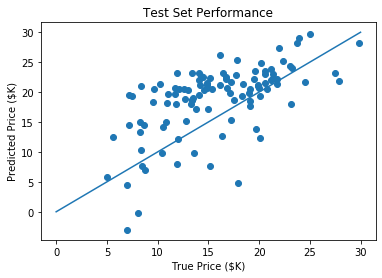

In [19]:
y_hat_k = net(X_norm_test)  # run the net on the whole dataset
y_unnormed_hat_k = np.sqrt(Y_var) * (y_hat_k) + Y_mean

# the following is code for producing the plot.
import matplotlib.pyplot as plt
plt.scatter(Y_test, y_unnormed_hat_k)
plt.plot(np.linspace(0, 30), np.linspace(0, 30))
plt.xlabel("True Price ($K)")
plt.ylabel("Predicted Price ($K)")
_ = plt.title("Test Set Performance")

## The Limits of Linear Models

Unsurprisingly, linear models can only approximate linear functions.
To give our neural network the ability to approximate nonlinear functions, we'll need to make its formula nonlinear somehow.

And, more nonlinear than affine :)

## Takeaways

* Neural networks can be used to approximate functions.
* Neural networks are **parametric**: They have parameters (weights and biases) that have to be optimized.
* The key algorithm for optimizing the weights and biases is called gradient descent.
* Gradient descent works by incrementally adjusting the parameters according to the rate of change of the error with respect to the parameter. This means:
    * The network must be "differentiable": You have to be able to find the (partial) derivative of the network's prediction with respect to each parameter.
    * The error function must be differentiable: You have to be able to find the (partial) derivative of the error with respect to the network's prediction.
* Linear neural networks can only approximate linear functions!

## Do On Your Owns

Neural networks are cool, but if you're using a linear model, all this SGD stuff can become cumbersome. So can numpy (and even pytorch). Scikit-learn is great for doing data science at this level. Learn how to do this linear regression with scikit-learn:

https://medium.com/@amitg0161/sklearn-linear-regression-tutorial-with-boston-house-dataset-cde74afd460a